# 1. Install Required Libraries

In [1]:
!pip install torch torchvision timm matplotlib seaborn numpy

# 2. Load Dataset and Display classes

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from collections import Counter

# Define transformations with ImageNet normalization and FIXED cropping issue
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images horizontally with 50% chance
    transforms.RandomRotation(10),      # Rotate images within ±10 degrees
    transforms.RandomCrop(32, padding=4),  # First crop images at 32x32
    transforms.Resize((224, 224)),  # Resize to 224x224 for ViT after cropping
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter for variety
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean & std
])

# Test set should not have augmentation, only resizing & normalization
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize only (No cropping needed)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset with fixed preprocessing
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Get dataset classes
classes = trainset.classes
print(f"Classes in CIFAR-10: {classes}")


Files already downloaded and verified
Files already downloaded and verified
Classes in CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# 3. Exploratory Data Analysis

## 3.1 Extract Labels and Plotting Class Distribution

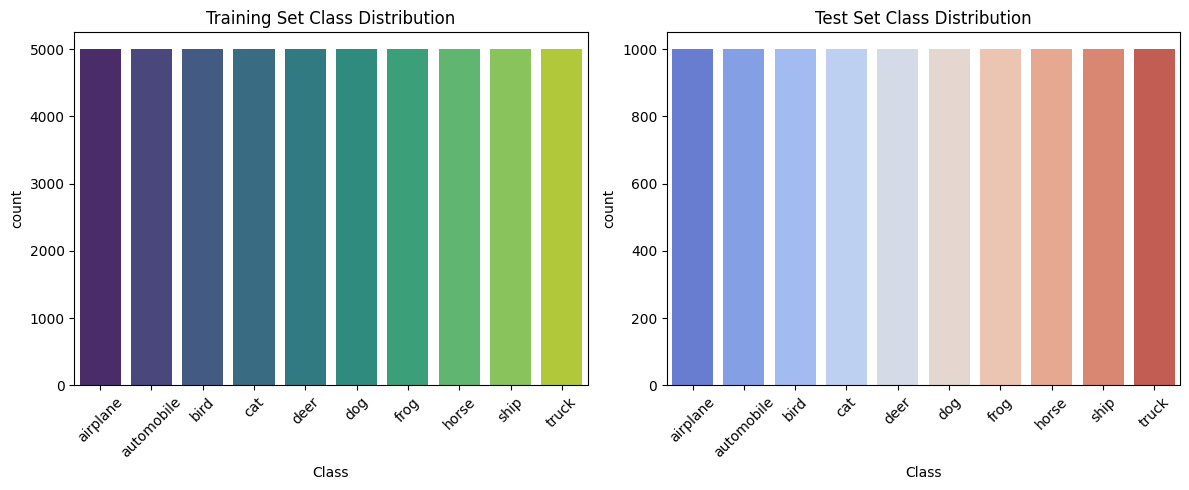

In [3]:
# Extract labels BEFORE applying transformations
train_labels = [label for _, label in torchvision.datasets.CIFAR10(root='./data', train=True, download=False)]
test_labels = [label for _, label in torchvision.datasets.CIFAR10(root='./data', train=False, download=False)]

# Convert to Pandas DataFrame for Seaborn plotting
import pandas as pd
train_labels_df = pd.DataFrame({"Class": train_labels})
test_labels_df = pd.DataFrame({"Class": test_labels})

# Plot class distribution for train and test sets
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x="Class", data=train_labels_df, ax=axes[0], palette="viridis")
sns.countplot(x="Class", data=test_labels_df, ax=axes[1], palette="coolwarm")

axes[0].set_title("Training Set Class Distribution")
axes[0].set_xticks(range(10))
axes[0].set_xticklabels(classes, rotation=45)

axes[1].set_title("Test Set Class Distribution")
axes[1].set_xticks(range(10))
axes[1].set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()


## 3.2. Display Sample Images

Sample Images After Preprocessing (Augmentation Applied):


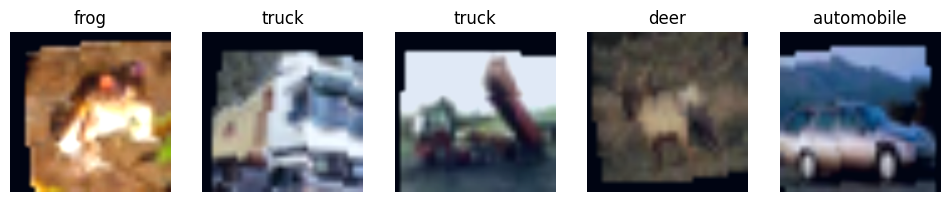

In [4]:
# Function to display sample images
def show_images(dataset, num_images=5):
    figure, axes = plt.subplots(1, num_images, figsize=(12, 6))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0) * 0.229 + 0.485)  # Unnormalize
        axes[i].set_title(classes[label])
        axes[i].axis("off")
    plt.show()

print("Sample Images After Preprocessing (Augmentation Applied):")
show_images(trainset)


## 3.3. Pixel Intensity Distribution

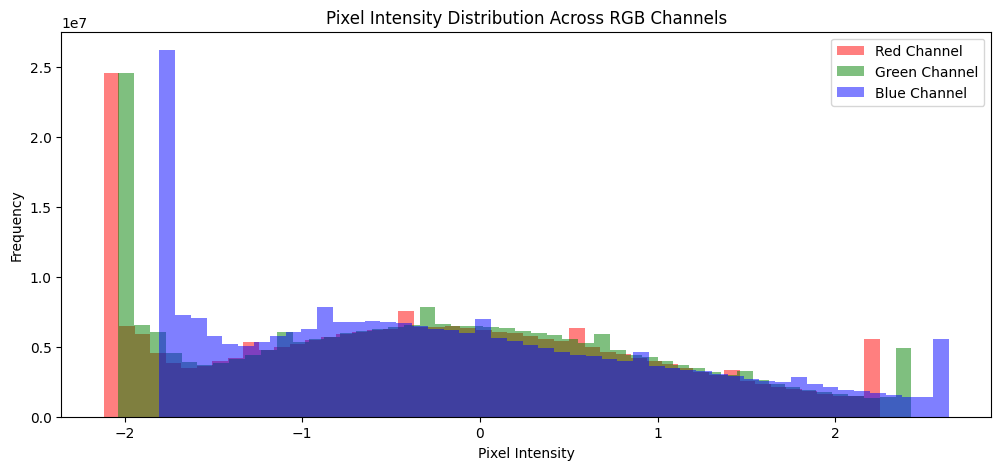

In [5]:
# Convert dataset images to numpy for histogram analysis
all_images = torch.stack([trainset[i][0] for i in range(5000)])  # Sample first 5000 images
all_images = all_images.permute(0, 2, 3, 1).numpy()

# Flatten images for histogram plots
red_channel = all_images[:, :, :, 0].flatten()
green_channel = all_images[:, :, :, 1].flatten()
blue_channel = all_images[:, :, :, 2].flatten()

# Plot histograms
plt.figure(figsize=(12, 5))
plt.hist(red_channel, bins=50, color='red', alpha=0.5, label='Red Channel')
plt.hist(green_channel, bins=50, color='green', alpha=0.5, label='Green Channel')
plt.hist(blue_channel, bins=50, color='blue', alpha=0.5, label='Blue Channel')
plt.legend()
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution Across RGB Channels")
plt.show()


## 3.4 Compute Correlation Matrix

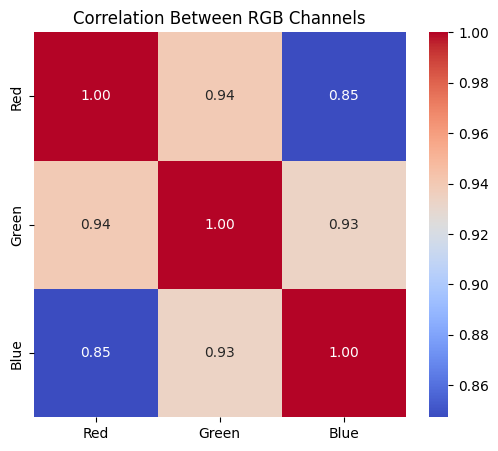

In [6]:
# Compute correlation matrix
pixel_values = np.stack([red_channel, green_channel, blue_channel], axis=1)
df_pixels = pd.DataFrame(pixel_values, columns=['Red', 'Green', 'Blue'])

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df_pixels.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between RGB Channels")
plt.show()


## 3.5 Distribution of Image Sharpness

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


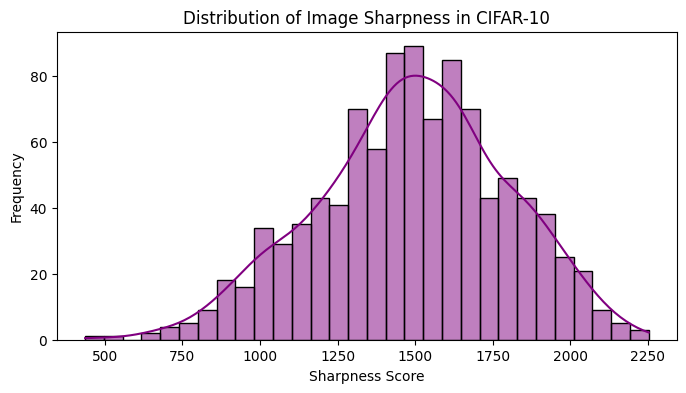

In [7]:
def compute_sharpness(image):
    image = image.numpy().transpose(1, 2, 0)
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    return np.mean(np.sqrt(sobelx**2 + sobely**2))

sharpness_scores = [compute_sharpness(trainset[i][0]) for i in range(1000)]

plt.figure(figsize=(8, 4))
sns.histplot(sharpness_scores, bins=30, kde=True, color='purple')
plt.xlabel("Sharpness Score")
plt.ylabel("Frequency")
plt.title("Distribution of Image Sharpness in CIFAR-10")
plt.show()


In [8]:
!pip install torch torchvision timm matplotlib numpy

In [9]:
import torch
from torch.utils.data import DataLoader

# Define batch size
BATCH_SIZE = 32

# DataLoaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# 4. Model Building

In [10]:
import timm
import torch.nn as nn

class ViTModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)  # Load Pre-trained ViT
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)  # Adjust final layer for 10 classes

    def forward(self, x):
        return self.vit(x)

# Initialize the model
model = ViTModel(num_classes=10).to(device)

# Print model summary
print(model)


ViTModel(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
     

## 4.1 Define Loss Function and Optimizer

In [11]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

## 4.2 Define Model

In [12]:
import torch
import time

# Training function with Mixed Precision
def train_model_amp(model, trainloader, epochs=10):
    model.train()
    scaler = torch.cuda.amp.GradScaler()  # Mixed Precision Scaler

    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients

            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss

            scaler.scale(loss).backward()  # Backpropagation
            scaler.step(optimizer)  # Optimizer step
            scaler.update()  # Update scaler

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}% - Time: {elapsed_time:.2f}s")

# Train model using mixed precision
train_model_amp(model, trainloader, epochs=10)


<ipython-input-12-c884da378143>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed Precision Scaler
<ipython-input-12-c884da378143>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


Epoch 1/10 - Loss: 0.3419 - Accuracy: 88.59% - Time: 456.05s
Epoch 2/10 - Loss: 0.2281 - Accuracy: 92.32% - Time: 467.81s
Epoch 3/10 - Loss: 0.1953 - Accuracy: 93.39% - Time: 467.90s
Epoch 4/10 - Loss: 0.1720 - Accuracy: 94.26% - Time: 466.74s
Epoch 5/10 - Loss: 0.1566 - Accuracy: 94.67% - Time: 466.27s
Epoch 6/10 - Loss: 0.1375 - Accuracy: 95.28% - Time: 464.70s
Epoch 7/10 - Loss: 0.1278 - Accuracy: 95.65% - Time: 464.43s
Epoch 8/10 - Loss: 0.1206 - Accuracy: 95.95% - Time: 464.70s
Epoch 9/10 - Loss: 0.1120 - Accuracy: 96.19% - Time: 464.53s
Epoch 10/10 - Loss: 0.1046 - Accuracy: 96.42% - Time: 463.87s


# 5. Model Evaluation

## 5.1 Test Model

In [13]:
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

# Evaluate model
test_model(model, testloader)


Test Accuracy: 94.61%


## 5.2 Attention Map Overlay

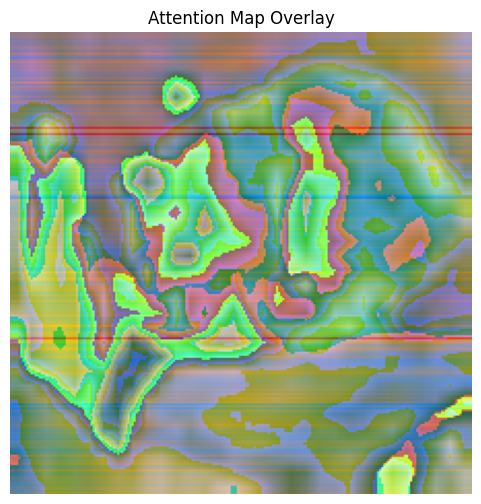

In [15]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_attention_map(model, image):
    model.eval()
    image = image.to(device).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model.vit.forward_features(image)  # Extract features from ViT
        attention_maps = model.vit.blocks[-1].attn.attn_drop(outputs)  # Get last block's attention map

    # Average across all attention heads
    attention_map = attention_maps.mean(dim=1)[0].cpu().numpy()

    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    return attention_map

def visualize_attention(image, model):
    attention_map = get_attention_map(model, image)

    # Resize to 224x224
    resized_attention = cv2.resize(attention_map, (224, 224))

    # Convert image to numpy
    image_np = image.cpu().permute(1, 2, 0).numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize for visualization

    # Convert to OpenCV format
    heatmap = cv2.applyColorMap(np.uint8(255 * resized_attention), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(cv2.cvtColor(np.uint8(255 * image_np * 255), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(blended)
    plt.axis("off")
    plt.title("Attention Map Overlay")
    plt.show()

# Select a test image
test_image, _ = testset[0]
visualize_attention(test_image, model)


## 5.3 Feature Map Visualisation

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


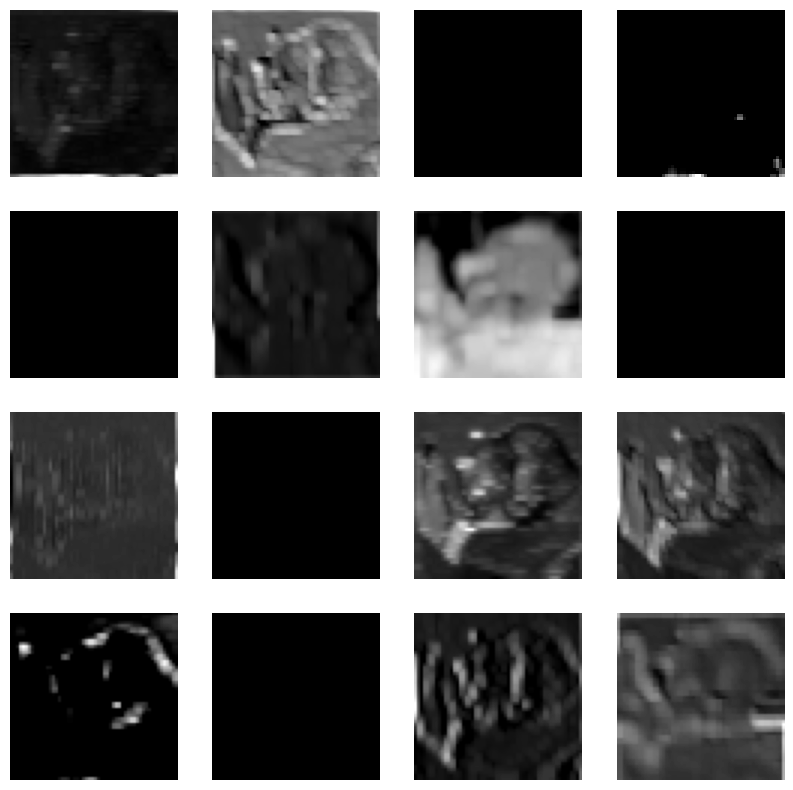

In [16]:
import torch.nn as nn
import torchvision.models as models

# Load Pretrained ResNet-18
resnet = models.resnet18(pretrained=True).to(device)

# Get Feature Maps from Early Convolutional Layers
def visualize_cnn_feature_maps(image, model):
    model.eval()
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        feature_extractor = nn.Sequential(*list(model.children())[:4])  # Extract early layers
        feature_maps = feature_extractor(image)

    feature_maps = feature_maps.cpu().squeeze(0)

    # Plot feature maps
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < feature_maps.shape[0]:
            ax.imshow(feature_maps[i].detach().numpy(), cmap='gray')
        ax.axis("off")
    plt.show()

# Select a test image
visualize_cnn_feature_maps(test_image, resnet)
